# Spandrel

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/notebooks/blob/main/notebooks/spandrel.ipynb)

[Spandrel](https://github.com/chaiNNer-org/spandrel) is the model loading library from [chaiNNer](https://github.com/chaiNNer-org/chaiNNer). It's meant for loading PyTorch super resolution models, like from [OpenModelDB](https://openmodeldb.info/). See [model architecture support](https://github.com/chaiNNer-org/spandrel#model-architecture-support).

In [1]:
# @title Install
import einops
import numpy as np
import os
import subprocess
import sys
import torch
from importlib.util import find_spec
from PIL import Image
from spandrel import ModelLoader
from urllib.request import urlopen, urlretrieve

modules = ["spandrel", "spandrel_extra_arches"]
if not all(find_spec(module) for module in modules):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *modules])
    os.kill(os.getpid(), 9)

In [2]:
# optional: install non-commercial architectures
# import spandrel_extra_arches
# _ = spandrel_extra_arches.install()

In [3]:
# convert to tensor, normalize to [0.0, 1.0], move to GPU, and rearrange
def preprocess(image_link_or_path):
    if os.path.exists(image_link_or_path):
        image = Image.open(image_link_or_path)
    else:
        image = urlopen(image_link_or_path)
        image = Image.open(image)

    image = image.convert("RGB")
    image = np.array(image).astype(np.float32) / 255.0
    image = torch.from_numpy(image).cuda()
    return einops.rearrange(image, "h w c -> 1 c h w")


# rearrange, denormalize to [0, 255], move to CPU, and convert to PIL
def postprocess(image_tensor):
    image = einops.rearrange(image_tensor, "1 c h w -> h w c")
    image = (image.clamp(0, 1) * 255).round().byte().cpu().numpy()  # byte is uint8
    return Image.fromarray(image)

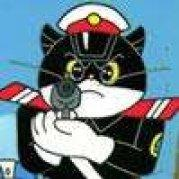

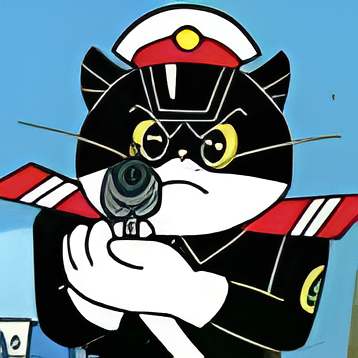

In [4]:
if not os.path.exists("RealESRGAN_x2plus.pth"):
    urlretrieve(
        "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth",
        "RealESRGAN_x2plus.pth",
    )
if not os.path.exists("cartoon_cat.jpg"):
    urlretrieve(
        "https://raw.githubusercontent.com/xinntao/Real-ESRGAN/refs/heads/master/inputs/0014.jpg",
        "cartoon_cat.jpg",
    )

model_2x = ModelLoader().load_from_file("RealESRGAN_x2plus.pth").cuda().eval()

with torch.inference_mode():
    image = preprocess("cartoon_cat.jpg")
    output = model_2x(image)
    output = postprocess(output)
    display(Image.open("cartoon_cat.jpg"))
    display(output)

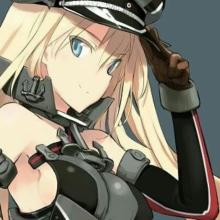

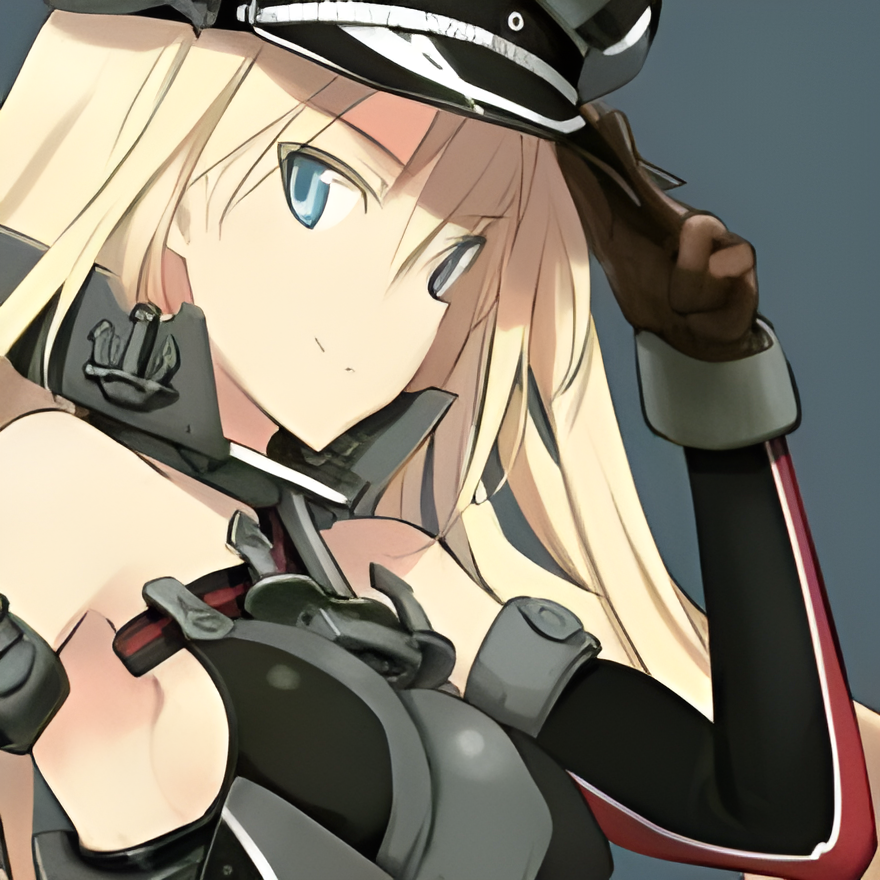

In [5]:
if not os.path.exists("RealESRGAN_x4plus.pth"):
    urlretrieve(
        "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth",
        "RealESRGAN_x4plus.pth",
    )
if not os.path.exists("anime_girl.jpg"):
    urlretrieve(
        "https://raw.githubusercontent.com/xinntao/Real-ESRGAN/refs/heads/master/inputs/0030.jpg",
        "anime_girl.jpg",
    )

model_4x = ModelLoader().load_from_file("RealESRGAN_x4plus.pth").cuda().eval()

with torch.inference_mode():
    image = preprocess("anime_girl.jpg")
    output = model_4x(image)
    output = postprocess(output)
    display(Image.open("anime_girl.jpg"))
    display(output)